In [1]:
!pip uninstall fastai -y
!pip install torch==1.8.1+cu102 torchvision==0.9.1+cu102 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Found existing installation: fastai 2.2.7
Uninstalling fastai-2.2.7:
  Successfully uninstalled fastai-2.2.7
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 804.1 MB 1.6 kB/s  eta 0:00:015     |██▉                             | 70.9 MB 50.4 MB/s eta 0:00:15     |████████▊                       | 218.4 MB 53.4 MB/s eta 0:00:11     |██████████▍                     | 260.6 MB 53.4 MB/s eta 0:00:11     |███████████▍                    | 285.2 MB 26.2 MB/s eta 0:00:20                    | 302.4 MB 642 kB/s eta 0:13:01     |████████████▏                   | 305.9 MB 642 kB/s eta 0:12:56     |████████████▎                   | 308.6 MB 642 kB/s eta 0:12:52     |████████████▊                   | 318.4 MB 642 kB/s eta 0:12:37     |████████████▊                   | 320.0 MB 642 kB/s eta 0:12:34     |███████████████████▌            | 489.6 MB 32.9 MB/s eta 0:00:10     |█████████████████████▎          | 535.2 MB 41.4 MB/s eta 0:00:07     

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy
import time
import shutil
import os

# for plotting
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

# for mAP evaluation
%rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
%rm -rf mAP/input/*

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 13.64 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [3]:
torch.__version__

'1.8.1+cu102'

In [4]:
def get_pascal_voc2007_data(image_root, split='train'):
  """
  import dataset from torcvision.dasasets
  it returns the pytorch dataset instance"""
  from torchvision import datasets

  train_dataset = datasets.VOCDetection(image_root, year='2007', image_set=split,
                                    download=True)
  
  return train_dataset

In [5]:
train_dataset = get_pascal_voc2007_data('/content', 'train')
val_dataset = get_pascal_voc2007_data('/content', 'val')
test_dataset = get_pascal_voc2007_data('/content', 'test')

  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting /content/VOCtrainval_06-Nov-2007.tar to /content
Using downloaded and verified file: /content/VOCtrainval_06-Nov-2007.tar
Extracting /content/VOCtrainval_06-Nov-2007.tar to /content


  0%|          | 0/451020800 [00:00<?, ?it/s]

Extracting /content/VOCtest_06-Nov-2007.tar to /content


In [6]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2501, 2510, 4952)

In [7]:
def pascal_voc2007_loader(dataset, batch_size, num_workers=0):
 
  from torch.utils.data import DataLoader
  
  # turn off shuffle so we can index the original image
  train_loader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False, pin_memory=True,
                            num_workers=num_workers,
                            collate_fn=voc_collate_fn)
  return train_loader


class_to_idx = {'aeroplane':0, 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4,
                'bus':5, 'car':6, 'cat':7, 'chair':8, 'cow':9, 'diningtable':10,
                'dog':11, 'horse':12, 'motorbike':13, 'person':14, 'pottedplant':15,
                'sheep':16, 'sofa':17, 'train':18, 'tvmonitor':19
}
idx_to_class = {i:c for c, i in class_to_idx.items()}


from torchvision import transforms

def voc_collate_fn(batch_lst, reshape_size=224):
    preprocess = transforms.Compose([
      transforms.Resize((reshape_size, reshape_size)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
    
    batch_size = len(batch_lst)
    
    img_batch = torch.zeros(batch_size, 3, reshape_size, reshape_size)
    
    max_num_box = max(len(batch_lst[i][1]['annotation']['object']) \
                      for i in range(batch_size))

    box_batch = torch.Tensor(batch_size, max_num_box, 5).fill_(-1.)
    w_list = []
    h_list = []
    img_id_list = []
    
    for i in range(batch_size):
      img, ann = batch_lst[i]
      w_list.append(img.size[0]) # image width
      h_list.append(img.size[1]) # image height
      img_id_list.append(ann['annotation']['filename'])
      img_batch[i] = preprocess(img)
      all_bbox = ann['annotation']['object']
      if type(all_bbox) == dict: # inconsistency in the annotation file
        all_bbox = [all_bbox]
      for bbox_idx, one_bbox in enumerate(all_bbox):
        bbox = one_bbox['bndbox']
        obj_cls = one_bbox['name']
        box_batch[i][bbox_idx] = torch.Tensor([float(bbox['xmin']), float(bbox['ymin']),
          float(bbox['xmax']), float(bbox['ymax']), class_to_idx[obj_cls]])
    
    h_batch = torch.tensor(h_list)
    w_batch = torch.tensor(w_list)

    return img_batch, box_batch, w_batch, h_batch, img_id_list

In [8]:
train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(0, 2500)) # use 2500 samples for training
train_loader = pascal_voc2007_loader(train_dataset, 10)
val_loader = pascal_voc2007_loader(val_dataset, 10)
test_loader = pascal_voc2007_loader(test_dataset, 10)

In [9]:
len(train_loader), len(val_loader), len(test_loader)

(250, 251, 496)

In [10]:
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = train_loader_iter.next()

print('img has shape: ', img.shape)
print('ann has shape: ', ann.shape)


img has shape:  torch.Size([10, 3, 224, 224])
ann has shape:  torch.Size([10, 6, 5])


We will use uniform cordinate transform system.
It is to make sure that we follow uniform cordinate system throught the process

In [11]:
def coord_trans(bbox, w_pixel, h_pixel, w_amap=7, h_amap=7, mode='a2p'):
  """
  Coordinate transformation function. It converts the box coordinate from
  the image coordinate system to the activation map coordinate system and vice versa.
  In our case, the input image will have a few hundred of pixels in
  width/height while the activation map is of size 7x7.
  
  """

  assert mode in ('p2a', 'a2p'), 'invalid coordinate transformation mode!'
  assert bbox.shape[-1] >= 4, 'the transformation is applied to the first 4 values of dim -1'
  
  if bbox.shape[0] == 0: # corner cases
    return bbox

  resized_bbox = bbox.detach().clone()
  
  resized_bbox = resized_bbox.view(bbox.shape[0], -1, bbox.shape[-1])
  invalid_bbox_mask = (resized_bbox == -1) # indicating invalid bbox

  if mode == 'p2a':
    # pixel to activation
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] /= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] /= height_ratio.view(-1, 1, 1)
  else:
    # activation to pixel
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] *= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] *= height_ratio.view(-1, 1, 1)

  resized_bbox.masked_fill_(invalid_bbox_mask, -1)
  resized_bbox.resize_as_(bbox)
  return resized_bbox

In [12]:
def plot_bbox(img, idx_to_class, bbox=None, pred=None):
  """
  Data visualizer on the original image. Support both GT box input and proposal input.
  """

  img_copy = np.array(img).astype('uint8')

  if bbox is not None:
    for bbox_idx in range(bbox.shape[0]):
      one_bbox = bbox[bbox_idx][:4]
      cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                  one_bbox[3]), (255, 0, 0), 2)
      if bbox.shape[1] > 4: # if class info provided
        obj_cls = idx_to_class[bbox[bbox_idx][4].item()]
        cv2.putText(img_copy, '%s' % (obj_cls),
                  (one_bbox[0], one_bbox[1]+15),
                  cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

  if pred is not None:
    for bbox_idx in range(pred.shape[0]):
      one_bbox = pred[bbox_idx][:4]
      cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                  one_bbox[3]), (0, 255, 0), 2)
      
      if pred.shape[1] > 4: # if class and conf score info provided
        obj_cls = idx_to_class[pred[bbox_idx][4].item()]
        conf_score = pred[bbox_idx][5].item()
        cv2.putText(img_copy, '%s, %.2f' % (obj_cls, conf_score),
                    (one_bbox[0], one_bbox[1]+15),
                    cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

  plt.imshow(img_copy)
  plt.axis('off')
  plt.show()

In [13]:
# fix_random_seed(0)
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 40
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
  img, ann = train_dataset.__getitem__(i)
  img_list.append(img)

  all_bbox = ann['annotation']['object']
  if type(all_bbox) == dict:
    all_bbox = [all_bbox]
  for bbox_idx, one_bbox in enumerate(all_bbox):
    bbox = one_bbox['bndbox']
    obj_cls = one_bbox['name']
    box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['xmin']), int(bbox['ymin']),
      int(bbox['xmax']), int(bbox['ymax']), class_to_idx[obj_cls]])

  # get sizes
  img = np.array(img)
  w_list.append(img.shape[1])
  h_list.append(img.shape[0])

w_list = torch.as_tensor(w_list, **to_float_cuda)
h_list = torch.as_tensor(h_list, **to_float_cuda)
box_list = torch.as_tensor(box_list, **to_float_cuda)
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a') # on activation map coordinate system

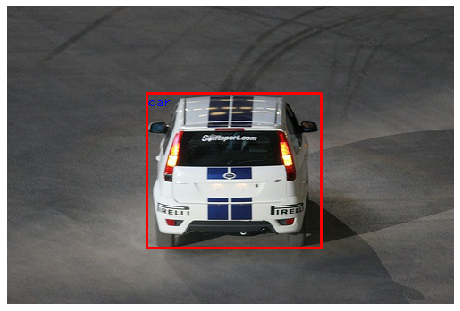

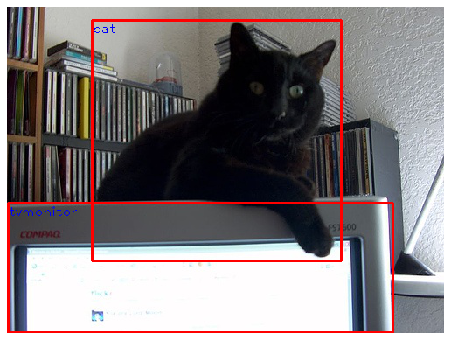

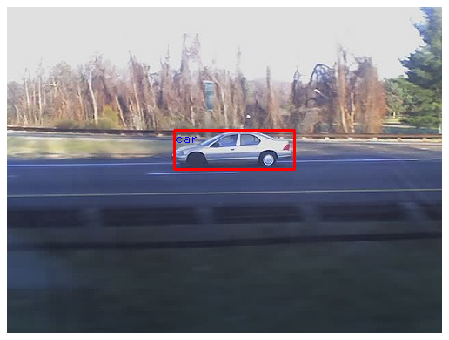

In [14]:
#visulalize bonding box
for i in range(len(img_list)):
  valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])
  plot_bbox(img_list[i], idx_to_class, box_list[i][:valid_box])

In [15]:
class Backbone(nn.Module):
  """
  Image feature extraction with MobileNet.
  """
  def __init__(self, reshape_size=224, pooling=False, verbose=False):
    super().__init__()

    from torchvision import models
    from torchsummary import summary

    self.mobilenet = models.mobilenet_v2(pretrained=True)
    self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1]) # Remove the last classifier

    # average pooling
    if pooling:
      self.mobilenet.add_module('LastAvgPool', nn.AvgPool2d(math.ceil(reshape_size/32.))) # input: N x 1280 x 7 x 7

    for i in self.mobilenet.named_parameters():
      i[1].requires_grad = True # fine-tune all

    if verbose:
      summary(self.mobilenet.cuda(), (3, reshape_size, reshape_size))
  
  def forward(self, x, verbose = False):
    num_img = x.shape[0]
    
    img_prepro = x

    feat = []
    process_batch = 500
    for b in range(math.ceil(num_img/process_batch)):
      feat.append(self.mobilenet(img_prepro[b*process_batch:(b+1)*process_batch]
                              ).squeeze(-1).squeeze(-1)) # forward and squeeze
    feat = torch.cat(feat)
    
    if verbose:
      print('Output feature shape: ', feat.shape)
    
    return feat

In [16]:
%%capture
!pip install torchsummary

In [17]:
#summary of mobileNet v2.
model = Backbone(verbose=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [18]:
# variable declaration for anchor box
anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]], **to_float_cuda)
print(anchor_list.shape)

torch.Size([9, 2])


In [19]:
def GenerateGrid(batch_size, w_amap=7, h_amap=7, dtype=torch.float32, device='cuda'):
  """
  Return a grid cell given a batch size (center coordinates).
  A float32 tensor of shape (B, H', W', 2) giving the (x, y) coordinates
      of the centers of each feature for a feature map of shape (B, D, H', W')
  """
  w_range = torch.arange(0, w_amap, dtype=dtype, device=device) + 0.5
  h_range = torch.arange(0, h_amap, dtype=dtype, device=device) + 0.5

  w_grid_idx = w_range.unsqueeze(0).repeat(h_amap, 1)
  h_grid_idx = h_range.unsqueeze(1).repeat(1, w_amap)
  grid = torch.stack([w_grid_idx, h_grid_idx], dim=-1)
  grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1)

  return grid


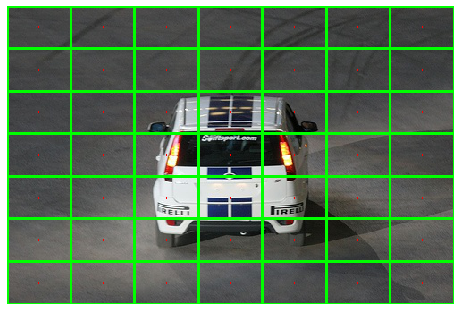

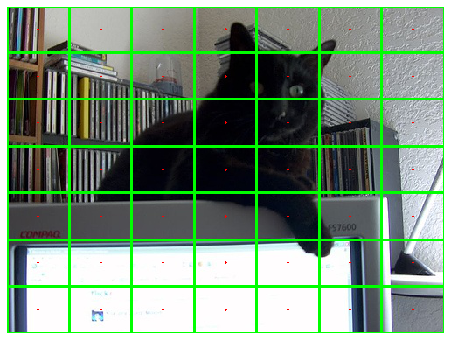

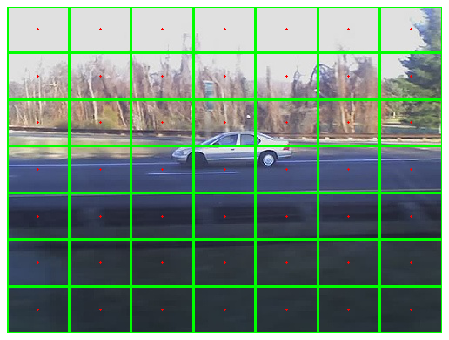

In [20]:
# visualization of Grid on the image
grid_list = GenerateGrid(w_list.shape[0])

center = torch.cat((grid_list, grid_list), dim=-1)
grid_cell = center.clone()
grid_cell[:, :, :, [0, 1]] -= 1. / 2.
grid_cell[:, :, :, [2, 3]] += 1. / 2.
center = coord_trans(center, w_list, h_list)
grid_cell = coord_trans(grid_cell, w_list, h_list)

for img, anc, grid in zip(img_list, center, grid_cell):
  plot_bbox(img, idx_to_class, anc.reshape(-1, 4), grid.reshape(-1, 4))

In [21]:
def GenerateAnchor(anc, grid):
  """
  Anchor generator.
  """
  anchors = None

  anchors = []

  # Get H', W' and A.
  Hp, Wp = grid.shape[1], grid.shape[2]
  A = anc.shape[0]
  for curr_grid in grid:
    # Initialize current image grid anchors.
    curr_grid_anc = torch.zeros((A, Hp, Wp, 4))
    for line, curr_gridl in enumerate(curr_grid):
      for col, curr_gridc in enumerate(curr_gridl):
        x, y = curr_gridc[0].item(), curr_gridc[1].item()  # Get the (x, y) center coordinates of the current grid.

        for idx_anc, curr_anc in enumerate(anc):
          anc_h, anc_w = curr_anc[0], curr_anc[1]  # Get current anchor box's height and width.
    
          x_tl, y_tl = (x - anc_h / 2), (y - anc_w / 2)
          x_br, y_br = (x + anc_h / 2), (y + anc_w / 2)
          # Add the position of 'curr_anc' to the current image grid anchors.
          curr_grid_anc[idx_anc, line, col] = torch.tensor((x_tl, y_tl, x_br, y_br))
    # Add the current image grid anchors to the list.
    anchors.append(curr_grid_anc)
  anchors = torch.stack(anchors).cuda()

  return anchors


In [22]:
def GenerateProposal(anchors, offsets, method='YOLO'):
  """
  Proposal generator.
  Returns Proposed region of shape  (B, A, H', W', 4)
  """
  assert(method in ['YOLO'])
  proposals = None

  # Create 'center_anchors' tensor having the same shape as 'anchors'.
  center_anchors = torch.zeros_like(anchors)

  center_anchors[..., 0] = (anchors[..., 0] + anchors[..., 2]) / 2
  center_anchors[..., 1] = (anchors[..., 1] + anchors[..., 3]) / 2
  center_anchors[..., 2] = anchors[..., 2] - anchors[..., 0]
  center_anchors[..., 3] = anchors[..., 3] - anchors[..., 1]

  # Center's shift differs depending on the method used.
  if method == 'YOLO':
    center_anchors[..., 0] += offsets[..., 0]
    center_anchors[..., 1] += offsets[..., 1]
 
  # Height/width's scale is similar for 'YOLO' and 'FasterRCNN'.
  center_anchors[..., 2] *= torch.exp(offsets[..., 2])
  center_anchors[..., 3] *= torch.exp(offsets[..., 3])

  # Create 'proposals' tensor having the same shape as 'center_anchors'.
  proposals = torch.zeros_like(center_anchors)
  proposals[..., 0] = center_anchors[..., 0] - center_anchors[..., 2] / 2 
  proposals[..., 1] = center_anchors[..., 1] - center_anchors[..., 3] / 2
  proposals[..., 2] = center_anchors[..., 0] + center_anchors[..., 2] / 2
  proposals[..., 3] = center_anchors[..., 1] + center_anchors[..., 3] / 2

  return proposals


In [23]:
def IoU(proposals, bboxes):
  """
  Compute intersection over union between sets of bounding boxes.

  """
  iou_mat = None
  proposals = torch.flatten(proposals, start_dim=1, end_dim=-2)
  proposals_area = (proposals[..., 2] - proposals[..., 0]) * \
                    (proposals[..., 3] - proposals[..., 1])

  bboxes = torch.unsqueeze(bboxes, dim=1)
  bboxes_area = (bboxes[..., 2] - bboxes[..., 0]) * \
                (bboxes[..., 3] - bboxes[..., 1])

  red_union = (proposals_area.T + bboxes_area.T).T
  proposals = torch.unsqueeze(proposals, dim=2)
  maxs = torch.maximum(bboxes[..., :4], proposals)
  mins = torch.minimum(bboxes[..., :4], proposals)
  inter_heights = mins[..., 2] - maxs[..., 0]
  inter_widths = mins[..., 3] - maxs[..., 1]
  inter_heights[inter_heights < 0] = 0
  inter_widths[inter_widths < 0] = 0
  inter_area = inter_heights * inter_widths

  # Compute the IoU, which equals to: Area of Intersection / Area of Union
  iou_mat = inter_area / (red_union - inter_area)

  return iou_mat


In [24]:
def ReferenceOnActivatedAnchors(anchors, bboxes, grid, iou_mat, pos_thresh=0.7, neg_thresh=0.3, method='FasterRCNN'):
  """
  Determine the activated (positive) and negative anchors for model training.
"""
  assert(method in ['YOLO'])

  B, A, h_amap, w_amap, _ = anchors.shape
  N = bboxes.shape[1]

  # activated/positive anchors
  max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
 
  bbox_mask = (bboxes[:, :, 0] != -1) # BxN, indicate invalid boxes
  bbox_centers = (bboxes[:, :, 2:4] - bboxes[:, :, :2]) / 2. + bboxes[:, :, :2] # BxNx2

  mah_dist = torch.abs(grid.view(B, -1, 2).unsqueeze(2) - bbox_centers.unsqueeze(1)).sum(dim=-1) # Bx(H'xW')xN
  min_mah_dist = mah_dist.min(dim=1, keepdim=True)[0] # Bx1xN
  grid_mask = (mah_dist == min_mah_dist).unsqueeze(1) # Bx1x(H'xW')xN

  reshaped_iou_mat = iou_mat.view(B, A, -1, N)
  anc_with_largest_iou = reshaped_iou_mat.max(dim=1, keepdim=True)[0] # Bx1x(H’xW’)xN
  anc_mask = (anc_with_largest_iou == reshaped_iou_mat) # BxAx(H’xW’)xN
  activated_anc_mask = (grid_mask & anc_mask).view(B, -1, N)
  activated_anc_mask &= bbox_mask.unsqueeze(1)
  
  # one anchor could match multiple GT boxes
  activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)
  GT_conf_scores = iou_mat.view(-1)[activated_anc_ind]
  bboxes = bboxes.view(B, 1, N, 5).repeat(1, A*h_amap*w_amap, 1, 1).view(-1, 5)[activated_anc_ind]
  GT_class = bboxes[:, 4].long()
  bboxes = bboxes[:, :4]
  activated_anc_ind = (activated_anc_ind / activated_anc_mask.shape[-1]).long()

  # print('number of pos proposals: ', activated_anc_ind.shape[0])
  activated_anc_coord = anchors.view(-1, 4)[activated_anc_ind]

  wh_offsets = torch.log((bboxes[:, 2:4] - bboxes[:, :2]) \
    / (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2]))

  xy_offsets = (bboxes[:, :2] + bboxes[:, 2:4] - \
    activated_anc_coord[:, :2] - activated_anc_coord[:, 2:4]) / 2.

  assert torch.max(torch.abs(xy_offsets)) <= 0.5, \
    "x and y offsets should be between -0.5 and 0.5! Got {}".format( \
    torch.max(torch.abs(xy_offsets)))

  GT_offsets = torch.cat((xy_offsets, wh_offsets), dim=-1)

  # negative anchors
  negative_anc_mask = (max_iou_per_anc < neg_thresh) # Bx(AxH’xW’)
  negative_anc_ind = torch.nonzero(negative_anc_mask.view(-1)).squeeze(-1)
  negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (activated_anc_ind.shape[0],))]
  negative_anc_coord = anchors.view(-1, 4)[negative_anc_ind.view(-1)]
  
  # activated_anc_coord and negative_anc_coord are mainly for visualization purposes
  return activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
         activated_anc_coord, negative_anc_coord

In [25]:
class PredictionNetwork(nn.Module):
  def __init__(self, in_dim, hidden_dim=128, num_anchors=9, num_classes=20, drop_ratio=0.3):
    super().__init__()

    assert(num_classes != 0 and num_anchors != 0)
    self.num_classes = num_classes
    self.num_anchors = num_anchors
    self.pred_layer = None
    last_cv_out = 5 * self.num_anchors + self.num_classes

    self.pred_layer = nn.Sequential(
      nn.Conv2d(in_channels=in_dim, out_channels=hidden_dim, kernel_size=1),
      nn.Dropout2d(p=drop_ratio),
      nn.LeakyReLU(),
      nn.Conv2d(in_channels=hidden_dim, out_channels=last_cv_out, kernel_size=1)
    )


  def _extract_anchor_data(self, anchor_data, anchor_idx):
    """
    Returns extracted_anchors: Tensor of shape (M, D) giving anchor data for each
    of the anchors specified by anchor_idx.
    """
    B, A, D, H, W = anchor_data.shape
    anchor_data = anchor_data.permute(0, 1, 3, 4, 2).contiguous().view(-1, D)
    extracted_anchors = anchor_data[anchor_idx]
    return extracted_anchors
  
  def _extract_class_scores(self, all_scores, anchor_idx):
    """
    Return  extracted_scores: Tensor of shape (M, C) giving the classification scores
    for each of the anchors specified by anchor_idx.
    """
    B, C, H, W = all_scores.shape
    A = self.num_anchors
    all_scores = all_scores.contiguous().permute(0, 2, 3, 1).contiguous()
    all_scores = all_scores.view(B, 1, H, W, C).expand(B, A, H, W, C)
    all_scores = all_scores.reshape(B * A * H * W, C)
    extracted_scores = all_scores[anchor_idx]
    return extracted_scores

  def forward(self, features, pos_anchor_idx=None, neg_anchor_idx=None):
    """
    Run the forward pass of the network to predict outputs given features
    from the backbone network.
    Returns conf_scores, offset, class_scores

    """
    conf_scores, offsets, class_scores = None, None, None
    B, _, H, W = features.shape
    A = self.num_anchors

    out_anchors = self.pred_layer(features)

    all_conf_scores = out_anchors[:, 0:5*A:5, ...]
    all_conf_scores = torch.sigmoid(all_conf_scores)

    all_offsets = out_anchors[:, :5*A, ...]

    all_offsets = all_offsets.reshape((B, A, 5, H, W))

    all_offsets = all_offsets[:, :, 1:, ...]

    all_offsets[:, :, :2, ...] = torch.sigmoid(all_offsets[:, :, :2, ...]) - 0.5

    all_class_scores = out_anchors[:, 5*A:, ...]

    if pos_anchor_idx is not None:  # Training mode.
      all_conf_scores = all_conf_scores.reshape((B, A, 1, H, W))
      pos_anc_conf = self._extract_anchor_data(all_conf_scores, pos_anchor_idx)
      neg_anc_conf = self._extract_anchor_data(all_conf_scores, neg_anchor_idx)
      conf_scores = torch.cat((pos_anc_conf, neg_anc_conf))
      # Offsets are retrieved only for positive anchors.
      offsets = self._extract_anchor_data(all_offsets, pos_anchor_idx)
      class_scores = self._extract_class_scores(all_class_scores, pos_anchor_idx)

    else:  # Inference mode..
      conf_scores = all_conf_scores
      offsets = all_offsets
      class_scores = all_class_scores

    return conf_scores, offsets, class_scores


In [26]:
def ConfScoreRegression(conf_scores, GT_conf_scores):
  """
  Returns confidence score loss
  """
  # the target conf_scores for negative samples are zeros
  GT_conf_scores = torch.cat((torch.ones_like(GT_conf_scores), \
                              torch.zeros_like(GT_conf_scores)), dim=0).view(-1, 1)
  conf_score_loss = torch.sum((conf_scores - GT_conf_scores)**2) * 1. / GT_conf_scores.shape[0]
  return conf_score_loss

In [27]:
def BboxRegression(offsets, GT_offsets):
  """"
  Returns bonding box loss
  """
  bbox_reg_loss = torch.sum((offsets - GT_offsets)**2) * 1. / GT_offsets.shape[0]
  return bbox_reg_loss

In [28]:
def ObjectClassification(class_prob, GT_class, batch_size, anc_per_img, activated_anc_ind):
  """"
  Returns object classification loss
  """
  all_loss = F.cross_entropy(class_prob, GT_class, reduction='none') # , reduction='sum') * 1. / batch_size
  object_cls_loss = 0
  for idx in range(batch_size):
    anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
    object_cls_loss += all_loss[anc_ind_in_img].sum() * 1. / torch.sum(anc_ind_in_img)
  object_cls_loss /= batch_size
  # object_cls_loss = F.cross_entropy(class_prob, GT_class, reduction='sum') * 1. / batch_size

  return object_cls_loss

In [29]:
class SingleStageDetector(nn.Module):
  def __init__(self):
    super().__init__()

    self.anchor_list = torch.tensor([[1., 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]]) # READ ONLY
    self.feat_extractor = Backbone()
    self.num_classes = 20
    self.pred_network = PredictionNetwork(1280, num_anchors=self.anchor_list.shape[0], \
                                          num_classes=self.num_classes)
  def forward(self, images, bboxes):
    """
    Training-time forward pass for the single-stage detector.
    Returns total_loss (Torch scalar giving the total loss for the batch).
    """
    # weights to multiple to each loss term
    w_conf = 1 # for conf_scores
    w_reg = 1 # for offsets
    w_cls = 1 # for class_prob

    total_loss = None

    batch_size = images.shape[0]

    #  Image feature extraction (using the backbone CNN network).
    features = self.feat_extractor(images)

    #  Grid and anchor generation.
    grid = GenerateGrid(batch_size)
    anchors = GenerateAnchor(self.anchor_list, grid)

    iou_mat = IoU(anchors, bboxes)
    activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, _, _ = \
        ReferenceOnActivatedAnchors(anchors, bboxes, grid, iou_mat, pos_thresh=0.7, 
                                    neg_thresh=0.2, method='YOLO')

    #  Compute conf_scores, offsets, class_scores through the prediction network.
    conf_scores, offsets, class_scores = self.pred_network(features, activated_anc_ind, negative_anc_ind)

    #  Compute the total loss.
    conf_loss = ConfScoreRegression(conf_scores, GT_conf_scores)
    reg_loss = BboxRegression(offsets, GT_offsets)
    _, A, H, W, _ = anchors.shape
    anc_per_img = A * H * W
    cls_loss = ObjectClassification(class_scores, GT_class, batch_size, anc_per_img, activated_anc_ind)

    total_loss = w_conf * conf_loss + w_reg * reg_loss + w_cls * cls_loss

    return total_loss
  
  def inference(self, images, thresh=0.5, nms_thresh=0.7):
    """"
    Inference-time forward pass for the single stage detector.
    Returns final_proposals, final_conf_scores, final_class. 
    """
    final_proposals, final_conf_scores, final_class = [], [], []
  
    batch_size = images.shape[0]

    # Image feature extraction (using the backbone CNN network).
    features = self.feat_extractor(images)

    # Grid and anchor generation.
    grid = GenerateGrid(batch_size)
    anchors = GenerateAnchor(self.anchor_list, grid)

    B, A, Hp, Wp, _ = anchors.shape

    conf_scores, offsets, class_scores = self.pred_network(features)
    conf_scores = torch.flatten(conf_scores, start_dim=1)
    offsets = torch.transpose(offsets, 2, 4)
    class_indices = torch.max(class_scores, dim=1)[1]
    class_indices = class_indices.unsqueeze(1)
    class_indices = torch.broadcast_to(class_indices, (B, A, Hp, Wp))
    class_indices = torch.flatten(class_indices, start_dim=1)
    proposals = GenerateProposal(anchors, offsets, method='YOLO')
    proposals = torch.flatten(proposals, start_dim=1, end_dim=-2)

    final_proposals, final_conf_scores, final_class = [], [], []

    for idx in range(batch_size):
      cr_proposal = proposals[idx]       # Tensor's shape: (A*H'*W', 4)
      cr_conf_scores = conf_scores[idx]  # Tensor's shape: (A*H'*W',)
      cr_classes = class_indices[idx]    # Tensor's shape: (A*H'*W',)

      del_idx_mask = ~ (cr_conf_scores < thresh)
      cr_conf_scores = cr_conf_scores[del_idx_mask]
      K = cr_conf_scores.shape[0]
      cr_classes = cr_classes[del_idx_mask].unsqueeze(1)
      del_idx_mask = del_idx_mask.unsqueeze(1)
      del_idx_mask = torch.broadcast_to(del_idx_mask, (A*Hp*Wp, 4))

      # 'cr_proposal' will have a shape of (K, 4)
      cr_proposal = cr_proposal[del_idx_mask].reshape(K, 4)

      icr_proposal = torchvision.ops.nms(cr_proposal, cr_conf_scores, nms_thresh)

      final_proposals.append(cr_proposal[icr_proposal])
      final_conf_scores.append(cr_conf_scores[icr_proposal].unsqueeze(1))
      final_class.append(cr_classes[icr_proposal])
    return final_proposals, final_conf_scores, final_class





In [30]:

def evaluator(detector, val_loader):
  detector.eval()
  start_t = time.time()
  data_batch = next(iter(val_loader))
  images, boxes, w_batch, h_batch, _ = data_batch
  resized_boxes = coord_trans(boxes, w_batch, h_batch, mode='p2a')
  images = images.to(**to_float_cuda)
  resized_boxes = resized_boxes.to(**to_float_cuda)
  loss_model = detector(images, resized_boxes)
  end_t = time.time()
  return loss_model.item(), end_t - start_t



In [31]:
def DetectionSolver(detector, train_loader, val_loader, learning_rate=3e-3,
                    lr_decay=1, num_epochs=20, **kwargs):
  """
  Run optimization to train the model.
  """

  # ship model to GPU
  detector.to(**to_float_cuda)

  # optimizer setup
  from torch import optim
  optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, detector.parameters()),
    learning_rate) # leaves betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  train_loss_history = []
  val_loss_history = []
  
  for i in range(num_epochs):
    start_t = time.time()
    for iter_num, data_batch in enumerate(train_loader):
      detector.train()
      images, boxes, w_batch, h_batch, _ = data_batch
      resized_boxes = coord_trans(boxes, w_batch, h_batch, mode='p2a')
      images = images.to(**to_float_cuda)
      resized_boxes = resized_boxes.to(**to_float_cuda)

      loss = detector(images, resized_boxes)
      optimizer.zero_grad()
      loss.backward()
      train_loss_history.append(loss.item())
      optimizer.step()
    
      print('(Iter {} / {})'.format(iter_num, len(train_loader)))
      with torch.no_grad():
          val_loss, val_duration = evaluator(detector, val_loader)
      val_loss_history.append(val_loss)
    end_t = time.time()
    print('(Epoch {} / {}) :-'.format(i, num_epochs))
    print('   train_loss: {:.4f} time per epoch: {:.1f}s'.format(
        loss.item(), end_t-start_t))
    print('   val_loss: {:.4f} time per epoch: {:.1f}s'.format(
          val_loss, val_duration))

    lr_scheduler.step()


   # plot the training losses
  plt.plot(train_loss_history, label ='training loss')
  plt.plot(val_loss_history, label ='validation loss')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Train_loss vs. val_loss')
  plt.legend()
  plt.show()


(Iter 0 / 25)
(Iter 1 / 25)
(Iter 2 / 25)
(Iter 3 / 25)
(Iter 4 / 25)
(Iter 5 / 25)
(Iter 6 / 25)
(Iter 7 / 25)
(Iter 8 / 25)
(Iter 9 / 25)
(Iter 10 / 25)
(Iter 11 / 25)
(Iter 12 / 25)
(Iter 13 / 25)
(Iter 14 / 25)
(Iter 15 / 25)
(Iter 16 / 25)
(Iter 17 / 25)
(Iter 18 / 25)
(Iter 19 / 25)
(Iter 20 / 25)
(Iter 21 / 25)
(Iter 22 / 25)
(Iter 23 / 25)
(Iter 24 / 25)
(Epoch 0 / 20) :-
   train_loss: 2.5375 time per epoch: 191.2s
   val_loss: 2.3119 time per epoch: 3.8s
(Iter 0 / 25)
(Iter 1 / 25)
(Iter 2 / 25)
(Iter 3 / 25)
(Iter 4 / 25)
(Iter 5 / 25)
(Iter 6 / 25)
(Iter 7 / 25)
(Iter 8 / 25)
(Iter 9 / 25)
(Iter 10 / 25)
(Iter 11 / 25)
(Iter 12 / 25)
(Iter 13 / 25)
(Iter 14 / 25)
(Iter 15 / 25)
(Iter 16 / 25)
(Iter 17 / 25)
(Iter 18 / 25)
(Iter 19 / 25)
(Iter 20 / 25)
(Iter 21 / 25)
(Iter 22 / 25)
(Iter 23 / 25)
(Iter 24 / 25)
(Epoch 1 / 20) :-
   train_loss: 1.8473 time per epoch: 190.2s
   val_loss: 1.7464 time per epoch: 3.8s
(Iter 0 / 25)
(Iter 1 / 25)
(Iter 2 / 25)
(Iter 3 / 25)
(Iter 

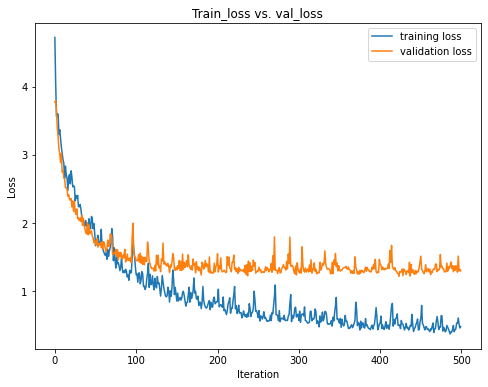

In [32]:
torch.cuda.empty_cache()

train_loader = pascal_voc2007_loader(train_dataset, 100)
val_loader = pascal_voc2007_loader(val_dataset, 100)
lr = 5e-2
num_epochs = 20
yolo_detector = SingleStageDetector().to(dtype=torch.float32, device='cuda')
DetectionSolver(yolo_detector, train_loader, val_loader, learning_rate=lr, num_epochs=num_epochs, dtype=torch.float32, device='cuda')

In [36]:
def DetectionInference(detector, data_loader, dataset, idx_to_class, thresh=0.8, nms_thresh=0.3, output_dir=None, dtype=torch.float32, device='cpu'):

  # ship model to GPU
  detector.to(dtype=dtype, device=device)
 
  detector.eval()
  start_t = time.time()

  if output_dir is not None:
    det_dir = 'mAP/input/detection-results'
    gt_dir = 'mAP/input/ground-truth'
    if os.path.exists(det_dir):
      shutil.rmtree(det_dir)
    os.mkdir(det_dir)
    if os.path.exists(gt_dir):
      shutil.rmtree(gt_dir)
    os.mkdir(gt_dir)

  # for iter_num, data_batch in enumerate(data_loader):
  data_batch = next(iter(data_loader))
  images, boxes, w_batch, h_batch, img_ids = data_batch
  images = images.to(dtype=dtype, device=device)

  final_proposals, final_conf_scores, final_class = detector.inference(images, thresh=thresh, nms_thresh=nms_thresh)

  # clamp on the proposal coordinates
  batch_size = len(images)
  for idx in range(batch_size):
    torch.clamp_(final_proposals[idx][:, 0::2], min=0, max=w_batch[idx])
    torch.clamp_(final_proposals[idx][:, 1::2], min=0, max=h_batch[idx])

    # visualization
      
    i = batch_size*0 + idx
    img, _ = dataset.__getitem__(i)

    valid_box = sum([1 if j != -1 else 0 for j in boxes[idx][:, 0]])
    final_all = torch.cat((final_proposals[idx], \
      final_class[idx].float(), final_conf_scores[idx]), dim=-1).cpu()
    resized_proposals = coord_trans(final_all, w_batch[idx], h_batch[idx])

    # write results to file for evaluation (use mAP API https://github.com/Cartucho/mAP for now...)
    if output_dir is not None:
      file_name = img_ids[idx].replace('.jpg', '.txt')
      with open(os.path.join(det_dir, file_name), 'w') as f_det, \
        open(os.path.join(gt_dir, file_name), 'w') as f_gt:
        for b in boxes[idx][:valid_box]:
          f_gt.write('{} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(idx_to_class[b[4].item()], b[0], b[1], b[2], b[3]))
        for b in resized_proposals:
          f_det.write('{} {:.6f} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(idx_to_class[b[4].item()], b[5], b[0], b[1], b[2], b[3]))
    else:
      plot_bbox(img, idx_to_class, boxes[idx][:valid_box], resized_proposals)


  end_t = time.time()
  print('Total inference time: {:.1f}s'.format(end_t-start_t))

In [37]:
torch.__version__


'1.8.1+cu102'

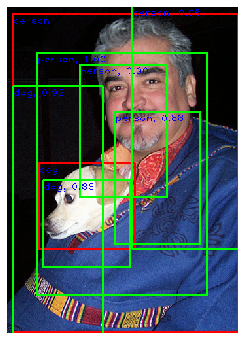

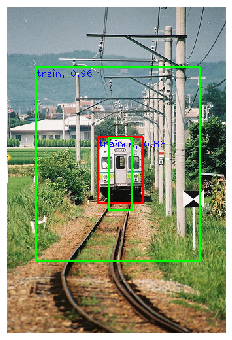

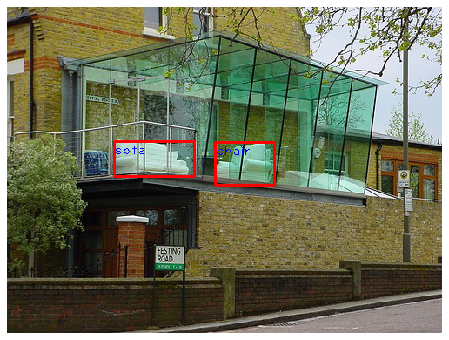

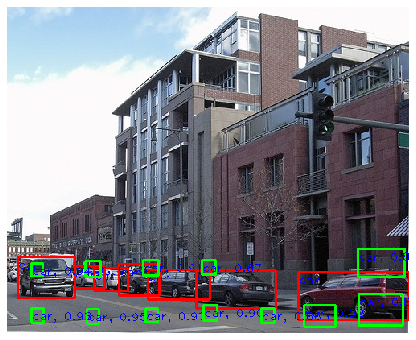

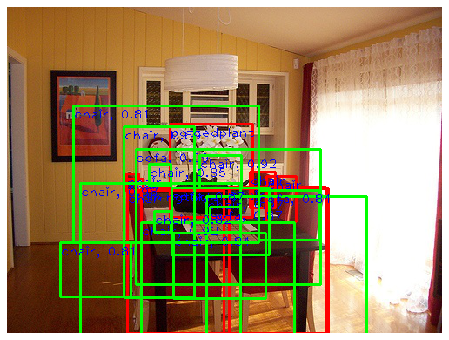

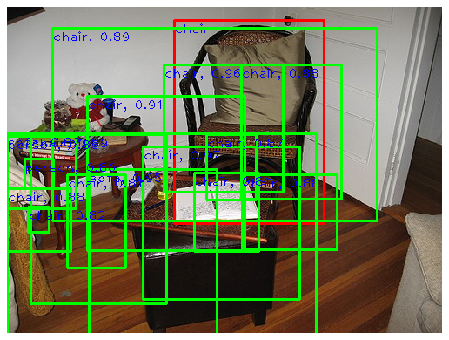

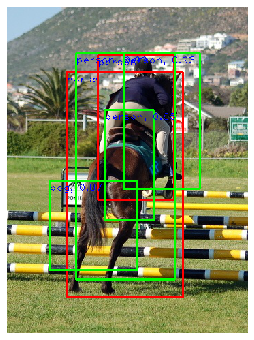

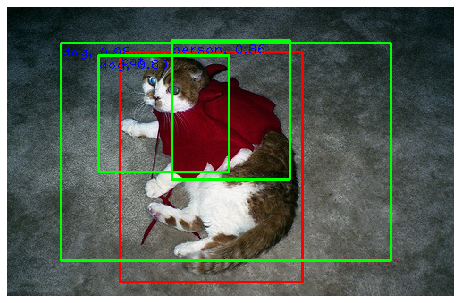

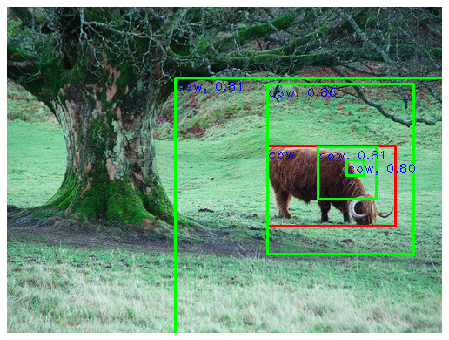

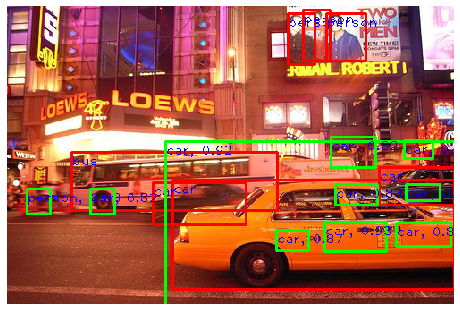

Total inference time: 1.7s


In [35]:
DetectionInference(yolo_detector, test_loader, test_dataset, idx_to_class, dtype=torch.float32, device='cuda')

In [38]:
DetectionInference(yolo_detector, val_loader, val_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3, device='cuda', dtype=torch.float32)
!cd mAP && python main.py

Total inference time: 4.1s
55.56% = aeroplane AP 
main.py:704: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('AP ' + class_name)
35.94% = bicycle AP 
20.62% = bird AP 
0.41% = boat AP 
0.00% = bottle AP 
0.00% = bus AP 
10.00% = car AP 
19.05% = cat AP 
0.48% = chair AP 
16.67% = cow AP 
15.00% = diningtable AP 
14.07% = dog AP 
18.52% = horse AP 
43.33% = motorbike AP 
14.70% = person AP 
0.00% = pottedplant AP 
0.00% = sheep AP 
1.25% = sofa AP 
40.00% = train AP 
0.75% = tvmonitor AP 
mAP = 15.32%
main.py:298: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(window_title)
